In [1]:
import os
import sys
import glob

sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand")
sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D")

from dataloader_ann import HandArmLandmarksDataset_ANN

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from datetime import datetime
import math

import open3d as o3d
from utilities import convert_to_shoulder_coord
import time

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from csv_writer import fusion_csv_columns_name
import matplotlib.pyplot as plt

import joblib
import sklearn

from scipy.spatial.transform import Rotation as R

from angle_calculation_v2 import calculate_angle_j1
from angle_calculation_v2 import calculate_angle_j2
from angle_calculation_v2 import calculate_six_arm_angles

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
arm_hand_fused_names = ["left shoulder", "left elbow", "left hip", "right shoulder", "right hip", 
 "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", "INDEX_FINGER_MCP", 
 "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", 
 "MIDDLE_FINGER_PIP", "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
 "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", "PINKY_MCP", "PINKY_PIP", 
 "PINKY_DIP", "PINKY_TIP", "right elbow"]

## Joint1 simulation

1. Random a bunch of landmarks and get joint 1 vector

2. Rotate it about a specified axis

3. Get joint 1 coordinates from cal_angle_j1_v2 

4. Plot

<IPython.core.display.Javascript object>


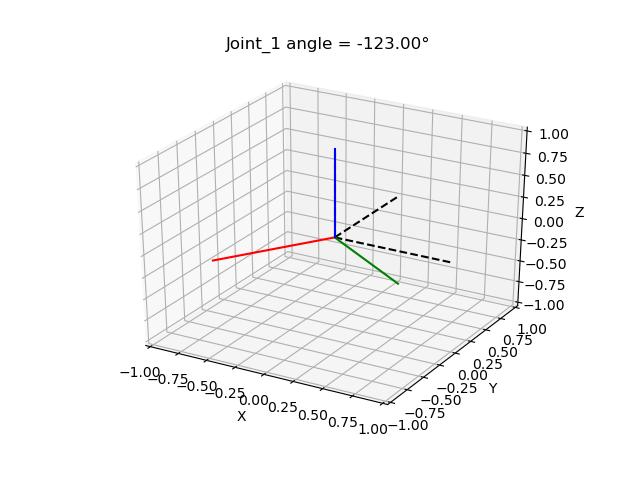

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

x_world, = ax.plot([0, 1], [0, 0], [0, 0], color='black', linestyle='--', label='x world')
y_world, = ax.plot([0, 0], [0, 1], [0, 0], color='black', linestyle='--', label='y world')
z_world, = ax.plot([0, 0], [0, 0], [0, 1], color='black', linestyle='--', label='z world')

random_vectors = np.random.rand(len(arm_hand_fused_names), 3)

random_vectors = np.random.rand(len(arm_hand_fused_names), 3)
random_vectors[arm_hand_fused_names.index("left elbow")] = [-1, 0, 0]

x_joint1, = ax.plot([0, 0], [0, 0], [0, 0], color='r', label='x_joint1')
y_joint1, = ax.plot([0, 0], [0, 0], [0, 0], color='g', label='y_joint1')
z_joint1, = ax.plot([0, 0], [0, 0], [0, 0], color='b', label='z_joint1')

def update(frame):
    process_landmarks = random_vectors.copy()
    theta = np.radians(frame)
    rotation_matrix_z = np.array([[np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]])
    
    x_elbow = process_landmarks[arm_hand_fused_names.index("left elbow")]
    rotated_vector = rotation_matrix_z @ x_elbow
    process_landmarks[arm_hand_fused_names.index("left elbow")] = rotated_vector
    
    joint_1_angle, joint1_rot_mat = calculate_angle_j1(process_landmarks, arm_hand_fused_names)
    
    x_joint1.set_data([0, joint1_rot_mat[0, 0]], [0, joint1_rot_mat[1, 0]])
    x_joint1.set_3d_properties([0, joint1_rot_mat[2, 0]])

    y_joint1.set_data([0, joint1_rot_mat[0, 1]], [0, joint1_rot_mat[1, 1]])
    y_joint1.set_3d_properties([0, joint1_rot_mat[2, 1]])
    
    z_joint1.set_data([0, joint1_rot_mat[0, 2]], [0, joint1_rot_mat[1, 2]])
    z_joint1.set_3d_properties([0, joint1_rot_mat[2, 2]])
    
    ax.set_title(f"Joint_1 angle = {joint_1_angle:.2f}°")

ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 3)[::-1], interval=100)

plt.show()


## Joint2 simulation

1. Random a bunch of landmarks and get joint 1 vector

2. Get joint1 rotation matrix

3. Rotate it about a specified axis

4. Get joint 2 coordinates from cal_angle_j2_v2 

5. Plot

In [20]:
#j1_psi_angles = [-87, -88, -89, -90, -91, -92]
#j1_psi_angles = np.linspace(0, -20, 20).round()
j1_psi_angles = [0]
j2_theta_angles = np.linspace(0, 95, 95).round()
#j3_phi_angles = np.linspace(0, 180, 180).round()
x, y = np.meshgrid(j1_psi_angles, j2_theta_angles)
x = x.T
x = x.reshape(-1)
y = y.T
y = y.reshape(-1)
given_angles = np.hstack([x[:, None], y[:, None]])

<IPython.core.display.Javascript object>


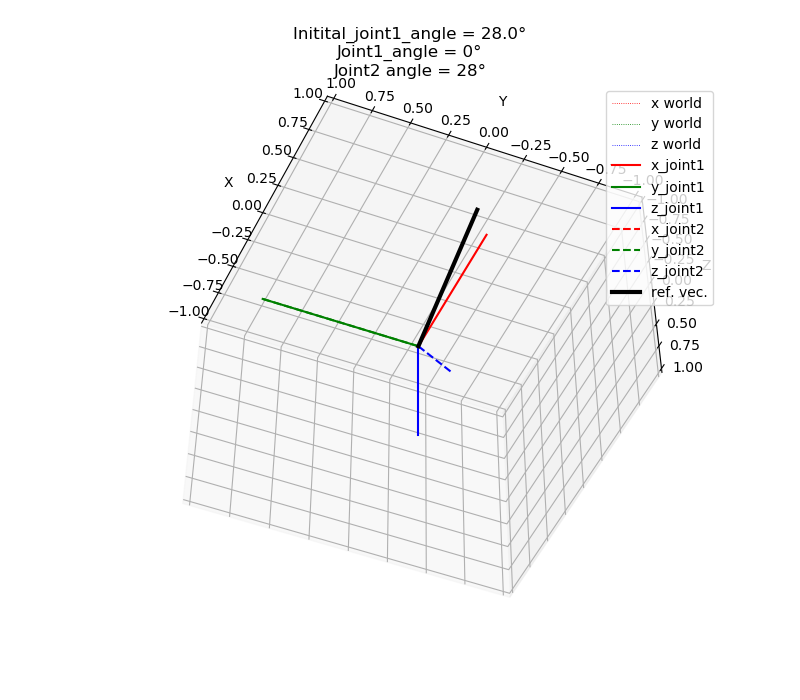

In [21]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

x_world, = ax.plot([0, 1], [0, 0], [0, 0], color='r', linestyle=':', label='x world', linewidth=0.6)
y_world, = ax.plot([0, 0], [0, 1], [0, 0], color='g', linestyle=':', label='y world', linewidth=0.6)
z_world, = ax.plot([0, 0], [0, 0], [0, 1], color='b', linestyle=':', label='z world', linewidth=0.6)

random_vectors = np.random.rand(len(arm_hand_fused_names), 3)
random_vectors[arm_hand_fused_names.index("left elbow")] = [-1, 0, 0]

plot_j1_x, = ax.plot([0, 0], [0, 0], [0, 0], color='r', label='x_joint1')
plot_j1_y, = ax.plot([0, 0], [0, 0], [0, 0], color='g', label='y_joint1')
plot_j1_z, = ax.plot([0, 0], [0, 0], [0, 0], color='b', label='z_joint1')

plot_j2_x, = ax.plot([0, 0], [0, 0], [0, 0], color='r', label='x_joint2', linestyle='--')
plot_j2_y, = ax.plot([0, 0], [0, 0], [0, 0], color='g', label='y_joint2', linestyle='--')
plot_j2_z, = ax.plot([0, 0], [0, 0], [0, 0], color='b', label='z_joint2', linestyle='--')

ref_vec, = ax.plot([0, random_vectors[arm_hand_fused_names.index("left elbow"), 0]], 
                   [0, random_vectors[arm_hand_fused_names.index("left elbow"), 1]], 
                   [0, random_vectors[arm_hand_fused_names.index("left elbow"), 2]], 
                   color='black', label='ref. vec.', linewidth=3)

ax.legend()

def update_plot(i):    
    process_landmarks = random_vectors.copy()
    angle_1, angle_2 = given_angles[i]
    angle_1_rad = np.radians(angle_1)
    angle_2_rad = np.radians(angle_2)
    rotation_matrix_z = np.array([[np.cos(angle_1_rad), -np.sin(angle_1_rad), 0],
        [np.sin(angle_1_rad),  np.cos(angle_1_rad), 0],
        [0, 0, 1]])
    rotation_matrix_y = np.array([[np.cos(angle_2_rad), 0, np.sin(angle_2_rad)],
        [0, 1, 0],
        [-np.sin(angle_2_rad), 0, np.cos(angle_2_rad)]])
    rotation_matrix_x = np.array([[1, 0, 0],
        [0, np.cos(angle_2_rad), -np.sin(angle_2_rad)],
        [0, np.sin(angle_2_rad), np.cos(angle_2_rad)]])
    
    rot_mat = rotation_matrix_z @ rotation_matrix_y
        
    x_elbow = process_landmarks[arm_hand_fused_names.index("left elbow")].copy()
    rotated_vector = rot_mat @ x_elbow
    process_landmarks[arm_hand_fused_names.index("left elbow")] = rotated_vector
    
    vec = -rotated_vector
    ref_vec.set_data([0, vec[0]], [0, vec[1]])
    ref_vec.set_3d_properties([0, vec[2]])
    
    """
    joint_1_angle, joint1_rot_mat = calculate_angle_j1(process_landmarks, arm_hand_fused_names)
    joint_2_angle, joint2_rot_mat, _ = calculate_angle_j2(process_landmarks, 
                                                          arm_hand_fused_names, 
                                                          joint1_rot_mat)
    """
    angles, rot_mats_wrt_origin, rot_mats_wrt_parent = calculate_six_arm_angles(process_landmarks,
        np.eye(3),
        arm_hand_fused_names)
    joint_1_angle, joint_2_angle = angles[0], angles[1]
    joint1_rot_mat, joint2_rot_mat = rot_mats_wrt_origin[0], rot_mats_wrt_origin[1]
        
    plot_j1_x.set_data([0, joint1_rot_mat[0, 0]], [0, joint1_rot_mat[1, 0]])
    plot_j1_x.set_3d_properties([0, joint1_rot_mat[2, 0]])
    plot_j1_y.set_data([0, joint1_rot_mat[0, 1]], [0, joint1_rot_mat[1, 1]])
    plot_j1_y.set_3d_properties([0, joint1_rot_mat[2, 1]])
    plot_j1_z.set_data([0, joint1_rot_mat[0, 2]], [0, joint1_rot_mat[1, 2]])
    plot_j1_z.set_3d_properties([0, joint1_rot_mat[2, 2]])   
        
    plot_j2_x.set_data([0, joint2_rot_mat[0, 0]], [0, joint2_rot_mat[1, 0]])
    plot_j2_x.set_3d_properties([0, joint2_rot_mat[2, 0]])
    plot_j2_y.set_data([0, joint2_rot_mat[0, 1]], [0, joint2_rot_mat[1, 1]])
    plot_j2_y.set_3d_properties([0, joint2_rot_mat[2, 1]])
    plot_j2_z.set_data([0, joint2_rot_mat[0, 2]], [0, joint2_rot_mat[1, 2]])
    plot_j2_z.set_3d_properties([0, joint2_rot_mat[2, 2]])
    
    ax.set_title("Initital_joint1_angle = {}°\nJoint1_angle = {}°\nJoint2 angle = {}°".format(
        angle_2,
        round(joint_1_angle), 
        round(joint_2_angle)))
    #ax.set_title("{}-{}\n{}".format(angle_1, angle_2, rotated_vector))
ani = FuncAnimation(fig, update_plot, frames=given_angles.shape[0], interval=100)

plt.show()